# Preliminary experiments

In [1]:
%config Completer.use_jedi = False


# imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function




%matplotlib inline

# Various
import numpy as np
import pandas as pd
from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, BatchNormalization, GRU, Lambda,\
TimeDistributed
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import History

from tensorflow.keras import backend as k
from tensorflow.keras import callbacks
from tensorflow import keras

# sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Project specific modules
# from losses import weibull_loglik_discrete, weibull_loglik_continuous
# from preprocessing import build_data
# from activations import activate

# math package
import math

# SHAP
import shap

/home/kefalasm/.local/lib/python3.8/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
tf.__version__

'2.4.1'

In [3]:
from tensorflow import keras

In [4]:
keras.__version__

'2.4.0'

In [5]:
import tensorflow_probability as tfp

In [6]:
tfp.__version__

'0.12.2'

## Utilities

In [7]:
from tqdm import tqdm

def build_data(units, time, x, max_time, is_test, mask_value, original_data, label='linear', **kwargs):
    """
    This function prepares the data by segmenting it into subsequences of length max_time
    by also padding, by pad_value, the time-steps when there is no data.

    :param units: identifier feature
    :param time: time-index feature
    :param x: sensor values (time-series)
    :param max_time: maximum lookback
    :param is_test: (boolean) test set or train set
    :param mask_value: value to pad the sequences
    :param **kwargs: additional arguments that might be used for other datasets
    :return: (ndarray) y. y[0] will be time remaining to an event, y[1] will be event indicator
    """

    # initializing output
    out_y = []

    # number of features/sensors
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []
    n_units = set(units)
    # print(n_units)
    for i in tqdm(n_units):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_unit_time = int(np.max(time[units == i])) + 1

        if is_test:
            start = max_unit_time - 1
        else:
            start = 0
        
        this_x = []

        for j in range(start, max_unit_time):

            engine_x = x[units == i]
            
               
            if is_test:
                original_max = original_data[original_data.unit_number==i].time.max()
                if label == 'linear':
                    out_y.append(original_max - j)
                else:
                    if j <= original_max/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (original_max - original_max/2)
                        rul = p * j - p * original_max
                        out_y.append(rul)

            else:
                if label == 'linear':
                    out_y.append(max_unit_time - j)
                else:
                    if j <= max_unit_time/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (max_unit_time - max_unit_time/2)
                        rul = p * j - p * max_unit_time
    #                     out_y.append(max_unit_time - j)
                        out_y.append(rul)

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value

            xtemp[:, max_time - min(j, max_time - 1) - 1:max_time, :] = engine_x[max(0, j - max_time + 1):j + 1, :]
            this_x.append(xtemp)

        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.array(out_y).reshape(len(out_y), 1) # np.concatenate(out_y) (uncomment when adding event. See comment above)
    return out_x, out_y


## Loss Function

In [8]:
def weibull_ttf(y, u, a, b):
    mttf = a * tf.exp(tf.math.lgamma(1 + 1/b))
      
    return k.square(y - mttf)


def loglik_discrete(y, u, a, b, epsilon=k.epsilon()):
    hazard0 = k.pow((y + epsilon) / a, b)
    hazard1 = k.pow((y + 1.0) / a, b)

    loglikelihoods = u * \
        k.log(k.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return loglikelihoods


def loglik_continuous(y, u, a, b, epsilon=k.epsilon()):
    ya = (y + epsilon) / a
 
    loglikelihoods = u * (k.log(b) + b * k.log(ya)) - k.pow(ya, b)
    return loglikelihoods


class CustomLoss(keras.losses.Loss):
    """ Creates a keras WTTE-loss function.
        - Usage
            :Example:
            .. code-block:: python
               loss = wtte.Loss(kind='discrete').loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01))
               # And with masking:
               loss = wtte.Loss(kind='discrete',reduce_loss=False).loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01),
                              sample_weight_mode='temporal')
        .. note::
            With masking keras needs to access each loss-contribution individually.
            Therefore we do not sum/reduce down to scalar (dim 1), instead return a 
            tensor (with reduce_loss=False).
        :param kind:  One of 'discrete' or 'continuous'
        :param reduce_loss: 
        :param clip_prob: Clip likelihood to [log(clip_prob),log(1-clip_prob)]
        :param regularize: Deprecated.
        :param location: Deprecated.
        :param growth: Deprecated.
        :type reduce_loss: Boolean
    """

    def __init__(self,
                 kind,
                 reduce_loss=False):
        super().__init__()
        self.kind = kind
        self.reduce_loss = reduce_loss

    def call(self, y_true, y_pred):
        
#         y, u = tf.unstack(y_true, axis=-1) # (uncomment when adding event)
        y = tf.cast(y_true, tf.float32) # (replace y_true -> y when adding event)
        y = tf.reshape(y, [-1]) # (coment when adding event)
#         u = tf.cast(u, tf.float32) # (uncomment when adding event)
        u = tf.constant(1, dtype=tf.float32) 
        a, b = tf.unstack(y_pred, axis=-1)
        
        if self.kind == 'discrete':
            loglikelihoods = loglik_discrete(y, u, a, b)
        elif self.kind == 'continuous':
            loglikelihoods = loglik_continuous(y, u, a, b)
        elif self.kind == 'mttf':
            loglikelihoods = weibull_ttf(y, u, a, b)
        
           
        if self.reduce_loss:
            loss = -1.0 * (k.mean(loglikelihoods, axis=-1)) # apparently this returns the same as the case below
        else:
            loss = -1.0 * loglikelihoods
        
        return loss
    
    def get_config(self):
        return {"kind": self.kind}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Activation Layer

In [71]:
class Activate(keras.layers.Layer):
    """ Elementwise computation of alpha and regularized beta.
        Wrapper to `output_lambda` using keras.layers.Activation. 
        See this for details.
        - Usage
            .. code-block:: python
               wtte_activation = wtte.OuputActivation(init_alpha=1.,
                                                 max_beta_value=4.0).activation
               model.add(Dense(2))
               model.add(Activation(wtte_activation))
    """

    def __init__(self, init_alpha=1.0, max_beta_value=1.0):
        super().__init__()
        self.init_alpha = init_alpha
        self.max_beta_value = max_beta_value
        

    def call(self, ab):
        """ (Internal function) Activation wrapper
        :param ab: original tensor with alpha and beta.
        :return ab: return of `output_lambda` with `init_alpha` and `max_beta_value`.
        """
        
        a, b = tf.unstack(ab, axis=-1)
#         print(a)
#         print(b)
        
#         a = k.exp(a)
#         b = k.softplus(b)
        
#         print(a)
#         print(b)
        
        # Implicitly initialize alpha:
        a = self.init_alpha * k.exp(a)

#         if self.max_beta_value > 1.05:  # some value >>1.0
#             # shift to start around 1.0
#             # assuming input is around 0.0
#             _shift = np.log(self.max_beta_value - 1.0)

#             b = b - _shift
        
    
        b = k.exp(b)  # self.max_beta_value * k.sigmoid(b) # this was affecting the max value of beta
        
        
#         a = a * tf.exp(tf.math.lgamma(1 + 1/b))
#         b = tf.repeat(1.0, tf.size(a))
        
        x = k.stack([a, b], axis=-1)
        
        return x
    
    def get_config(self):
        return {"init_alpha": self.init_alpha, "max_beta_value":self.max_beta_value}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## A simple network

Sequential form

In [10]:
def network(train_X, train_y, test_X, test_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
#     tensorboard = callbacks.TensorBoard(log_dir = './logs_2D')

    n_features = train_X.shape[-1]

    # Start building our model
    model = Sequential()
    # Mask parts of the lookback period that are all _mask_value_ (i.e., unobserved) so they don't skew the model
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
#     model.add(BatchNormalization())
    model.add(GRU(100, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
#     model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
#     model.add(BatchNormalization())
    model.add(GRU(20, activation='tanh', recurrent_dropout=0.25, return_sequences=False))
    model.add(Dense(2))
    custom_activation = Activate()
#     model.add(BatchNormalization())
    model.add(Activation(custom_activation))

    
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss=CustomLoss(kind='continuous', reduce_loss=True), optimizer=Adam(lr=.01, clipvalue=0.5))#, metrics=['mse', rmse]) #CustomLoss(kind='mttf', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping], # , tensorboard
              workers=32)
    

    return model, history

Functional form

In [35]:
def network_model(train_X, train_y, test_X, test_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
#     tensorboard = callbacks.TensorBoard(log_dir = './logs_2D')
    
    window = train_x.shape[1]
    n_features = train_X.shape[2]
    
    inputs = keras.Input(shape=(window, n_features))
    masking_layer = keras.layers.Masking(mask_value=mask_value)(inputs)
    gru_1 = keras.layers.GRU(100, activation='tanh', dropout=0.25,  recurrent_dropout=0.25, return_sequences=True)(masking_layer)
    gru_2 = keras.layers.GRU(50, activation='tanh', dropout=0.25, recurrent_dropout=0.25, return_sequences=True)(gru_1)
    gru_3 = keras.layers.GRU(20, activation='tanh', dropout=0.25, recurrent_dropout=0.25, return_sequences=False)(gru_2)
    dense_1 = keras.layers.Dense(2)(gru_3)
    custom_activation = Activate()
    outputs = keras.layers.Activation(custom_activation)(dense_1)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="weibull_params")

    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss=CustomLoss(kind='continuous', reduce_loss=True), optimizer=Adam(lr=.01, clipvalue=0.5))#, metrics=['mse', rmse]) #CustomLoss(kind='mttf', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping], # , tensorboard
              workers=32)
    

    return model, history

### Weibull specific functions

In [12]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [13]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [14]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [15]:
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

In [16]:
def weibull_std(alpha, beta):
    return alpha**2 * (math.gamma(1+2/beta) - math.gamma(1+1/beta)**2)

## Dataset 1 - CMAPSS

In [17]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [18]:
train_x_orig = pd.read_csv('./DataSets/CMAPSS/train_FD001.csv', header=None, sep='\s+', decimal=".")
# train_x_orig.drop(train_x_orig.columns[[-1, -2]], axis=1, inplace=True)
train_x_orig.columns = column_names

test_x_orig = pd.read_csv('./DataSets/CMAPSS/test_FD001.csv', header=None, sep='\s+', decimal=".")
# test_x_orig.drop(test_x_orig.columns[[-1, -2]], axis=1, inplace=True)
test_x_orig.columns = column_names

test_y_orig = pd.read_csv('./DataSets/CMAPSS/RUL_FD001.csv', header=None, names=['T'])
# test_y_orig.drop(test_y_orig.columns[[-1]], axis=1, inplace=True)


# Old import way
# train_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)
# test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)
# test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [19]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [20]:
train_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [21]:
train_x_orig

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [22]:
train_x_orig[train_x_orig.unit_number.isin([0,1,2])].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            469, 470, 471, 472, 473, 474, 475, 476, 477, 478],
           dtype='int64', length=479)

### Data pre-processing

In [23]:
# Make engine numbers and days zero-indexed, for everybody's sanity
train_x_orig.iloc[:, 0:2] -= 1
test_x_orig.iloc[:, 0:2] -= 1

In [24]:
# always observed in our case
# test_y_orig.set_index(np.arange(1, test_y_orig.shape[0]+1), inplace=True)
# test_y_orig['E'] = 1 # (uncomment when adding event)

In [25]:
test_y_orig

,T
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [26]:
train_x_orig

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,0,0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,0,2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0,3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,0,4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,99,195,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,99,196,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,99,197,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,99,198,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [27]:
test_x_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,0,0,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,0,1,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,0,2,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,0,3,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,0,4,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [28]:
train_x_orig.shape

(20631, 26)

In [29]:
test_x_orig.shape

(13096, 26)

***

***

### K-fold CV

In [56]:
try:
    del model
except NameError:
    pass

In [57]:
k.clear_session()

In [58]:
# parameters

max_time = 100 
mask_value = -99
cv = 10
shuffle = True
random_state = 21
reps = 30

epochs = 10
batch_size = 64

In [59]:
kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

  8%|▊         | 7/90 [00:00<00:01, 67.05it/s]

 Starting CV with: CV = 10, shuffle = True, random_state = 21 
 and model parameters: epochs = 10, batch_size = 64, max_time = 100, mask_value = -99
Fold: 1


100%|██████████| 10/10 [00:00<00:00, 1613.63it/s]


train_x (18597, 100, 17) train_y (18597, 1) test_x (10, 100, 17) test_y (10, 1)
Model: "weibull_params"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 17)]         0         
_________________________________________________________________
masking_1 (Masking)          (None, 100, 17)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 100)          35700     
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 50)           22800     
_________________________________________________________________
gru_5 (GRU)                  (None, 20)                4320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
______________________________________

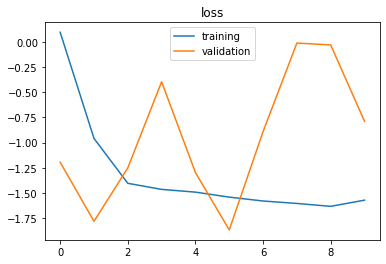

In [72]:
print(f' Starting CV with: CV = {cv}, shuffle = {shuffle}, random_state = {random_state} \n and model parameters: epochs = {epochs}, batch_size =\
 {batch_size}, max_time = {max_time}, mask_value = {mask_value}')

rmse_train = []
r2_train = []
mae_train = []

rmse_test = []
r2_test = []
mae_test = []

train_all = []
test_all = []

file = 'RUL_SA_prelim_results_cmapss_1st_linear.csv'
columns = ['fold', 'rmse_train', 'mae_train', 'r2_train', 'rmse_test', 'mae_test', 'r2_test']
results = pd.DataFrame(columns=columns)

fold_count = 0
      
start = time.time()

for train_units, test_units in kf.split(train_x_orig.unit_number.unique()):
    
    fold_count+= 1
    print(f'Fold: {fold_count}')
    tf.random.set_seed(fold_count)
    
    # Selecting data
    train_index = train_x_orig[train_x_orig.unit_number.isin(train_units)].index
    test_index = train_x_orig[train_x_orig.unit_number.isin(test_units)].index # careful this was wrongly test_x_orig. It should be train_x_orig

    X_train = train_x_orig.iloc[train_index]
    X_test_or = train_x_orig.iloc[test_index] # careful this was wrongly test_x_orig. It should be train_x_orig
    
    X_train.reset_index(drop=True, inplace=True)
    X_test = X_test_or.reset_index(drop=True, inplace=False) # changed for debugging
    
    
    # Truncating test data randomly
    X_test_trunc = []
    test_y = []
    max_cycle = []
    test_index = [] # for debugging purposes
    temp_or_test_cycles = []
    for i in set(X_test.unit_number.unique()):
        np.random.seed(i)
#         print(i)
        temp_df = X_test[X_test.unit_number==i]
        temp_df.reset_index(drop=True, inplace=True) # important
        length = temp_df.shape[0]
        temp_or_test_cycles.append(length)
        level = np.random.choice(np.arange(5, 96), 1)[0]  
        r = np.int(length*(1-level/100))
        test_index.append(X_test_or[X_test_or.unit_number==i].index.tolist()[:r+1]) # check this with train_x_orig instead of X_test_or (probably it's the same)
        temp_df = temp_df.truncate(after=r)
        max_cycle.append(temp_df.shape[0])
        X_test_trunc.append(temp_df)

    test_index = [item for sublist in test_index for item in sublist]
    
    X_test_trunc = pd.concat(X_test_trunc)
    X_test_trunc.reset_index(drop=True, inplace=True)

   
    # Pre-processing data
    scaler=pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())])

    train = X_train.copy()
    train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)
    
    test = X_test_trunc.copy()
    test = np.concatenate([test[['unit_number', 'time']], scaler.transform(test[feature_cols])], axis=1)
    
    
    # Preparing data for the RNN (numpy arrays)
    train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                                  is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')

    test_x, test_y = build_data(units=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time,
                       is_test=True, mask_value=mask_value, original_data=X_test_or, label='nonlinear') 
     
    # initialization
    tte_mean_train = np.nanmean(train_y)#[:, 0]) # (uncomment when adding event)
    mean_u = 1.0 #np.nanmean(train_y[:, 1]) # (uncomment when adding event)

    # Initialization value for alpha-bias
#     init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
#     init_alpha = init_alpha / mean_u
    # print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)
    init_alpha = None

    print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)
    
   
    # training
    model, history = network_model(train_x, train_y, test_x, test_y, mask_value, epochs, batch_size, init_alpha)
    
    plt.plot(history.history['loss'],    label='training')
    plt.plot(history.history['val_loss'],label='validation')
    plt.title('loss')
    plt.legend()
    
    # predicting the rul on the train fold
    train_predict_1 = []
    train_predict_2 = []
    predicted_mu = []
    for i in range(reps):
#         print(i)
        tf.random.set_seed(i)
        train_predict = model(train_x, training=True).numpy()
        train_predict_1.append(train_predict[:,0].reshape(train_predict[:,0].shape[0], 1))
        train_predict_2.append(train_predict[:,1].reshape(train_predict[:,1].shape[0], 1))
    
    train_predict_1_mean = np.average(np.hstack(train_predict_1), axis=1)
    train_predict_2_mean = np.average(np.hstack(train_predict_2), axis=1)
    train_predict_1_mean = train_predict_1_mean.reshape(train_predict_1_mean.shape[0],1)
    train_predict_2_mean = train_predict_2_mean.reshape(train_predict_2_mean.shape[0],1)
    train_predict_1_std = np.std(np.hstack(train_predict_1), axis=1)
    train_predict_2_std = np.std(np.hstack(train_predict_2), axis=1)
    train_predict_1_std = train_predict_1_std.reshape(train_predict_1_std.shape[0],1)
    train_predict_2_std = train_predict_2_std.reshape(train_predict_2_std.shape[0],1)
    
    
    train_predict = np.hstack([train_predict_1_mean, train_predict_2_mean, 
                               train_predict_1_std, train_predict_2_std])    

    
    train_predict = np.resize(train_predict, (train_x.shape[0], 4))  # changed from 2 to 4
    train_result = np.concatenate((train_y, train_predict), axis=1)
    train_results_df = pd.DataFrame(train_result, columns=['T', 'mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']) # (add 'E' for event)
    train_results_df['unit_number'] = train_x_orig.iloc[train_index]['unit_number'].to_numpy()
    train_results_df['time'] = train_x_orig.iloc[train_index]['time'].to_numpy()
    
    train_results_df['predicted_mu'] = train_results_df[['mean_alpha', 'mean_beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    train_results_df['predicted_std+'] = train_results_df[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                           'std_beta']].apply(lambda row: weibull_mean(row[0]+1.96*row[2]/np.sqrt(reps), 
                                                                                                       row[1]+1.96*row[3]/np.sqrt(reps)), axis=1)
    train_results_df['predicted_std-'] = train_results_df[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                           'std_beta']].apply(lambda row: weibull_mean(row[0]-1.96*row[2]/np.sqrt(reps), 
                                                                                                 row[1]-1.96*row[3]/np.sqrt(reps)), axis=1)
    # predicting the rul on the test fold
    test_predict_1 = []
    test_predict_2 = []
    for i in range(reps):
        tf.random.set_seed(i)
        test_predict = model(test_x, training=True).numpy()
        test_predict_1.append(test_predict[:,0].reshape(test_predict[:,0].shape[0], 1))
        test_predict_2.append(test_predict[:,1].reshape(test_predict[:,1].shape[0], 1))
    
    test_predict_1_mean = np.average(np.hstack(test_predict_1), axis=1)
    test_predict_2_mean = np.average(np.hstack(test_predict_2), axis=1)
    test_predict_1_mean = test_predict_1_mean.reshape(test_predict_1_mean.shape[0],1)
    test_predict_2_mean = test_predict_2_mean.reshape(test_predict_2_mean.shape[0],1)
    test_predict_1_std = np.std(np.hstack(test_predict_1), axis=1)
    test_predict_2_std = np.std(np.hstack(test_predict_2), axis=1)
    test_predict_1_std = test_predict_1_std.reshape(test_predict_1_std.shape[0],1)
    test_predict_2_std = test_predict_2_std.reshape(test_predict_2_std.shape[0],1)
    
       
    test_predict = np.hstack([test_predict_1_mean, test_predict_2_mean, 
                               test_predict_1_std, test_predict_2_std])    
    
    test_predict = np.resize(test_predict, (test_x.shape[0], 4))  # changed from 2 to 4
    test_result = np.concatenate((test_y, test_predict), axis=1)
    test_results_df = pd.DataFrame(test_result, columns=['T',   'mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']) # (add 'E' for event)
#     test_results_df['unit_number'] = train_x_orig.iloc[test_index]['unit_number'].to_numpy() # Note the train_x_orig
#     test_results_df['time'] = train_x_orig.iloc[test_index]['time'].to_numpy()
    
    test_results_df['predicted_mu'] = test_results_df[['mean_alpha', 'mean_beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    test_results_df['predicted_std+'] = test_results_df[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                           'std_beta']].apply(lambda row: weibull_mean(row[0]+1.96*row[2]/np.sqrt(reps), 
                                                                                                       row[1]+1.96*row[3]/np.sqrt(reps)), axis=1)
    test_results_df['predicted_std-'] = test_results_df[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                           'std_beta']].apply(lambda row: weibull_mean(row[0]-1.96*row[2]/np.sqrt(reps), 
                                                                                                       row[1]-1.96*row[3]/np.sqrt(reps)), axis=1)
    #  general administration
    train_all.append(train_results_df)
    test_all.append(test_results_df)
    
    # performance evaluation
    # train:
    rmse_train.append(np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T'])))
    mae_train.append((mean_absolute_error(train_results_df['predicted_mu'], train_results_df['T'])))
    r2_train.append(r2_score(train_results_df['predicted_mu'], train_results_df['T']))
    
    # test:
    rmse_test.append(np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T'])))
    mae_test.append((mean_absolute_error(test_results_df['predicted_mu'], test_results_df['T'])))
    r2_test.append(r2_score(test_results_df['predicted_mu'], test_results_df['T']))
    
    # registering results
    results['fold'] = [fold_count]
    results['rmse_train'] = [rmse_train[-1]]
    results['mae_train'] = [mae_train[-1]]
    results['r2_train'] = [r2_train[-1]]
    results['std_train'] = np.average(train_results_df['predicted_std+'] - train_results_df['predicted_std-'])
    results['rmse_test'] = [rmse_test[-1]]
    results['mae_test'] = [mae_test[-1]]
    results['r2_test'] = [r2_test[-1]]   
    results['std_test'] = np.average(test_results_df['predicted_std+']-test_results_df['predicted_std-'])
    
    print(results)
    
    if os.path.isfile(file):
        results.to_csv('./' + file, mode='a', index=False, header=False)
    else:
        results.to_csv('./' + file, mode='w', index=False, header=True)
    
#     k.clear_session()
#     del model
    
    break

end = time.time()
print(f'Elapsed time: {(end - start)/60} minutes')

***

saving

In [41]:
# model.save('./model')

In [42]:
# model = keras.models.load_model('./model', custom_objects={"CustomLoss": CustomLoss, "Activate": Activate})

***

In [61]:
train_results_df

,T,mean_alpha,mean_beta,std_alpha,std_beta,unit_number,time,predicted_mu,predicted_std+,predicted_std-
0,130.0,127.946785,27.389004,0.919649,0.191407,0,0,125.413599,125.742117,125.085084
1,130.0,129.595352,27.662481,0.360739,0.055548,0,1,127.053326,127.181597,126.925056
2,130.0,129.688751,27.672596,0.393544,0.068713,0,2,127.145765,127.285952,127.005580
3,130.0,129.807190,27.687092,0.312647,0.048450,0,3,127.263132,127.374314,127.151951
4,130.0,129.846390,27.685713,0.257486,0.052368,0,4,127.301445,127.393396,127.209494
...,...,...,...,...,...,...,...,...,...,...
18592,6.5,21.537720,2.853260,9.606490,1.145535,99,195,19.192331,22.390735,16.051111
18593,5.2,21.113714,2.819902,12.489503,1.498583,99,196,18.805827,22.967999,14.744384
18594,3.9,19.314257,2.595436,9.871247,1.227219,99,197,17.154232,20.411978,13.976511
18595,2.6,22.796795,2.918919,13.541973,1.278904,99,198,20.333151,24.824875,15.921320


In [62]:
test_results_df

,T,mean_alpha,mean_beta,std_alpha,std_beta,predicted_mu,predicted_std+,predicted_std-
0,98.222222,102.555069,10.628102,13.580020,4.489089,97.812940,103.007750,92.524366
1,130.000000,128.721375,26.488758,5.090261,4.002748,126.091820,128.004556,124.169397
2,78.461538,97.149193,9.179096,13.374417,4.207739,92.078622,97.242710,86.804477
3,130.000000,130.094803,27.719347,0.080861,0.055521,127.547892,127.577974,127.517809
4,130.000000,130.067932,27.720867,0.149834,0.040566,127.521679,127.575498,127.467859
5,95.740072,100.345459,9.613382,12.743688,2.715584,95.302282,100.038402,90.536266
6,130.000000,129.890518,27.683748,0.637831,0.143994,127.344539,127.572756,127.116321
7,109.260700,125.858330,24.997843,12.231997,5.980414,123.144380,127.634638,118.634618
8,60.115607,75.885994,7.166074,11.098845,0.743747,71.072732,74.931614,67.220842
9,130.000000,129.772339,27.663227,0.504083,0.109614,127.226906,127.407138,127.046674


In [63]:
for i in test_results_df.index:
    print(f'prediction: {i} --> alpha CI: [{test_results_df.iloc[i]["mean_alpha"] - 1.96*test_results_df.iloc[i]["std_alpha"]},\
          {test_results_df.iloc[i]["mean_alpha"] + 1.96*test_results_df.iloc[i]["std_alpha"]}]')
    print(f'prediction: {i} --> beta CI: [{test_results_df.iloc[i]["mean_beta"] - 1.96*test_results_df.iloc[i]["std_beta"]}, \
          {test_results_df.iloc[i]["mean_beta"] + 1.96*test_results_df.iloc[i]["std_beta"]}]')
    print('\n')

prediction: 0 --> alpha CI: [75.93822986602783,          129.1719080734253]
prediction: 0 --> beta CI: [1.8294887733459468,           19.426715831756592]


prediction: 1 --> alpha CI: [118.74446298599243,          138.69828603744506]
prediction: 1 --> beta CI: [18.643371047973634,           34.334145126342776]


prediction: 2 --> alpha CI: [70.93533489227295,          123.36305072784424]
prediction: 2 --> beta CI: [0.9319280242919916,           17.426264419555665]


prediction: 3 --> alpha CI: [129.93631590545178,          130.25328980743885]
prediction: 3 --> beta CI: [27.610525022000076,           27.828168978244065]


prediction: 4 --> alpha CI: [129.7742568910122,          130.3616073668003]
prediction: 4 --> beta CI: [27.64135739326477,           27.800376920700074]


prediction: 5 --> alpha CI: [75.36783123016357,          125.32308673858643]
prediction: 5 --> beta CI: [4.290838088989258,           14.93592658996582]


prediction: 6 --> alpha CI: [128.6403692483902,          131.

Dedicated test set

In [64]:
test_or = test_x_orig.copy()
test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


# Preparing data for the RNN (numpy arrays)
test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=max_time,
                   is_test=True, mask_value=mask_value, original_data=test_x_orig)


100%|██████████| 100/100 [00:00<00:00, 866.01it/s]


In [65]:
test_predict_1_or = []
test_predict_2_or = []
for _ in range(reps):
    test_predict_or = model(test_or, training=True).numpy()
#     print(test_predict_or.shape)
#     break
    test_predict_1_or.append(test_predict_or[:,0].reshape(test_predict_or[:,0].shape[0], 1))
    test_predict_2_or.append(test_predict_or[:,1].reshape(test_predict_or[:,1].shape[0], 1))

test_predict_1_mean_or = np.average(np.hstack(test_predict_1_or), axis=1)
test_predict_2_mean_or = np.average(np.hstack(test_predict_2_or), axis=1)
test_predict_1_mean_or = test_predict_1_mean_or.reshape(test_predict_1_mean_or.shape[0],1)
test_predict_2_mean_or = test_predict_2_mean_or.reshape(test_predict_2_mean_or.shape[0],1)
test_predict_1_std_or = np.std(np.hstack(test_predict_1_or), axis=1)
test_predict_2_std_or = np.std(np.hstack(test_predict_2_or), axis=1)
test_predict_1_std_or = test_predict_1_std_or.reshape(test_predict_1_std_or.shape[0],1)
test_predict_2_std_or = test_predict_2_std_or.reshape(test_predict_2_std_or.shape[0],1)


test_predict_or = np.hstack([test_predict_1_mean_or, test_predict_2_mean_or, 
                           test_predict_1_std_or, test_predict_2_std_or])    

test_predict_or = np.resize(test_predict_or, (test_or.shape[0], 4))  # changed from 2 to 4
test_result_or = np.concatenate((test_y_orig, test_predict_or), axis=1)
test_results_df_or = pd.DataFrame(test_result_or, columns=['T',   'mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']) # (add 'E' for event)
#     test_results_df['unit_number'] = train_x_orig.iloc[test_index]['unit_number'].to_numpy() # Note the train_x_orig
#     test_results_df['time'] = train_x_orig.iloc[test_index]['time'].to_numpy()

test_results_df_or['predicted_mu'] = test_results_df_or[['mean_alpha', 'mean_beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df_or['predicted_std+'] = test_results_df_or[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                       'std_beta']].apply(lambda row: weibull_mean(row[0]+1.96*row[2]/np.sqrt(reps), 
                                                                                                   row[1]+1.96*row[3]/np.sqrt(reps)), axis=1)
test_results_df_or['predicted_std-'] = test_results_df_or[['mean_alpha', 'mean_beta', 'std_alpha', 
                                                           'std_beta']].apply(lambda row: weibull_mean(row[0]-1.96*row[2]/np.sqrt(reps),
                                                                                                       row[1]-1.96*row[3]/np.sqrt(reps)), axis=1)




# Old way
# test_predict_or = model(test_or, training=True).numpy()  # equivalent to model.predict(test_or) but with training=False
# test_predict_or = np.resize(test_predict_or, (test_or.shape[0], 2))
# test_result_or = np.concatenate((test_y_orig, test_predict_or), axis=1)
# test_results_df_or = pd.DataFrame(test_result_or, columns=['T', 'alpha', 'beta'])
# test_results_df_or['unit_number'] = np.arange(1, test_results_df_or.shape[0]+1)

# test_results_df_or['predicted_mu'] = test_results_df_or[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)

In [66]:
np.sqrt(mean_squared_error(test_results_df_or['predicted_mu'], test_results_df_or['T']))

22.96483082921626

Some plotting

In [50]:
def surv(alpha, beta, t):
    return np.exp(-np.power(t/alpha, beta))

In [51]:
t=np.arange(0,100)
a = 30
ex1 = surv(a, 0.9, t)
ex2 = surv(a, 2, t)
ex3 = surv(a, 5, t)

plt.subplots(figsize=(30, 10))

plt.plot(t, ex1, label='a:'+str(a)+', b:'+str(0.9))
plt.plot(t, ex2, label='a:'+str(a)+', b:'+str(2))
plt.plot(t, ex3, label='a:'+str(a)+', b:'+str(5))

plt.legend()


In [75]:
survs = pd.DataFrame()

t=np.arange(0,400)
mean_alpha, mean_beta, std_alpha, std_beta = test_results_df.iloc[0][['mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']]

survs['mean'] = surv(mean_alpha, mean_beta, t)
survs['mean+std'] = surv(mean_alpha+1.96*std_alpha/np.sqrt(reps), mean_beta+1.96*std_beta/np.sqrt(reps), t)
survs['mean-std'] = surv(mean_alpha-1.96*std_alpha/np.sqrt(reps), mean_beta-1.96*std_beta/np.sqrt(reps), t)

survs1 = pd.DataFrame()

mean_alpha, mean_beta, std_alpha, std_beta = test_results_df.iloc[2][['mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']]

survs1['mean'] = surv(mean_alpha, mean_beta, t)
survs1['mean+std'] = surv(mean_alpha+1.96*std_alpha/np.sqrt(reps), mean_beta+1.96*std_beta/np.sqrt(reps), t)
survs1['mean-std'] = surv(mean_alpha-1.96*std_alpha/np.sqrt(reps), mean_beta-1.96*std_beta/np.sqrt(reps), t)

survs2 = pd.DataFrame()

mean_alpha, mean_beta, std_alpha, std_beta = test_results_df.iloc[4][['mean_alpha', 'mean_beta', 'std_alpha', 'std_beta']]

survs2['mean'] = surv(mean_alpha, mean_beta, t)
survs2['mean+std'] = surv(mean_alpha+1.96*std_alpha/np.sqrt(reps), mean_beta+1.96*std_beta/np.sqrt(reps), t)
survs2['mean-std'] = surv(mean_alpha-1.96*std_alpha/np.sqrt(reps), mean_beta-1.96*std_beta/np.sqrt(reps), t)

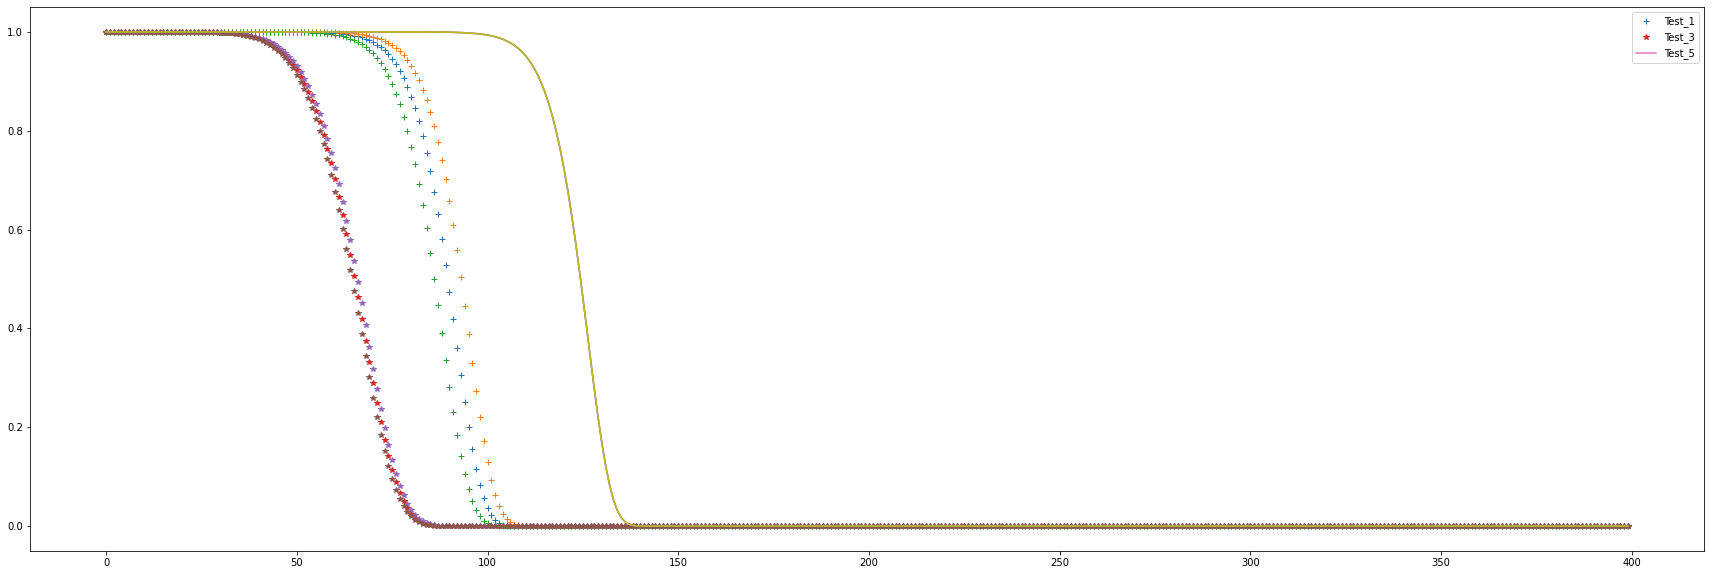

In [85]:
plt.subplots(figsize=(30, 10))

plt.plot(t, survs['mean'], '+', label='Test_1')
plt.plot(t, survs['mean+std'], '+')
plt.plot(t, survs['mean-std'], '+')

plt.plot(t, survs1['mean'], '*', label='Test_3')
plt.plot(t, survs1['mean+std'], '*')
plt.plot(t, survs1['mean-std'], '*')

plt.plot(t, survs2['mean'], label='Test_5')
plt.plot(t, survs2['mean+std'])
plt.plot(t, survs2['mean-std'])

plt.legend()

# sns.lineplot(data=survs.iloc[:, [0,1,2,3,4,5,6,7]], legend='auto')

# # for k in survs.columns:
# #     sns.lineplot(x=survs.index, y=k ,data=survs)


<function matplotlib.pyplot.legend(*args, **kwargs)>

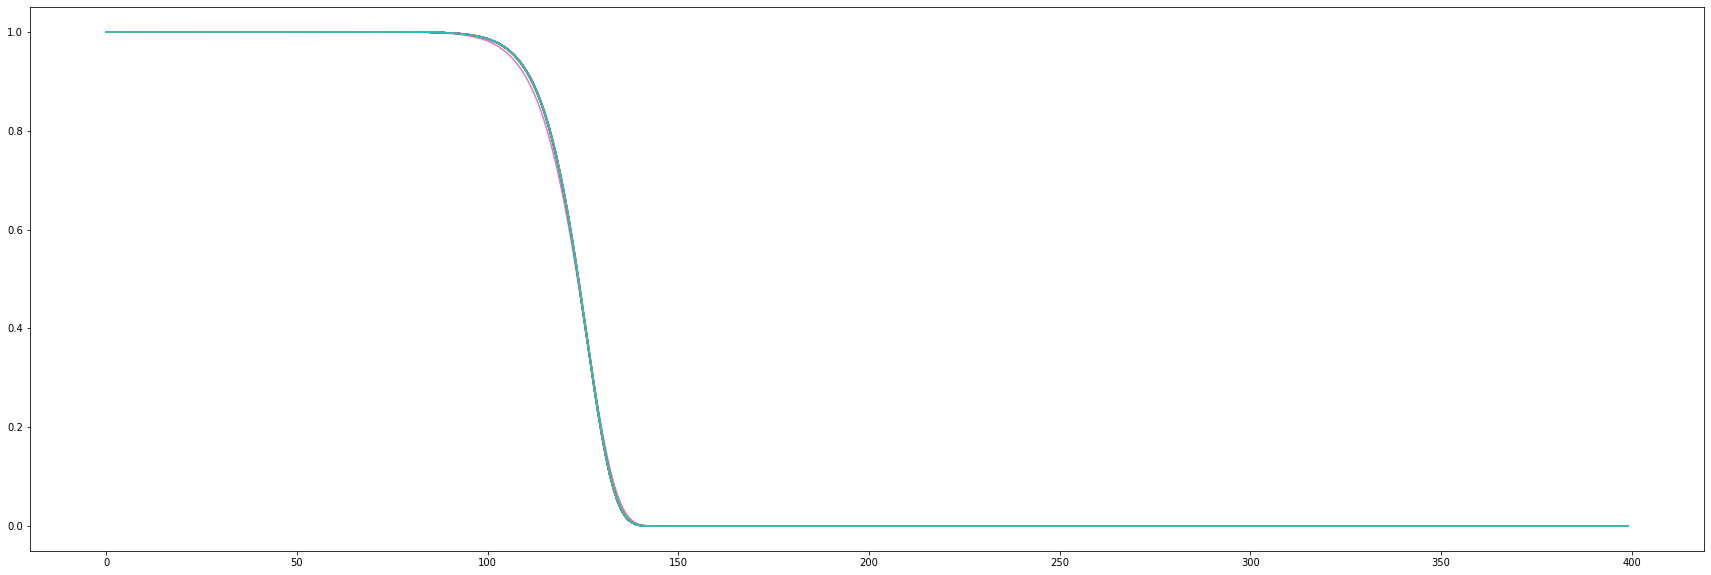

In [284]:
plt.subplots(figsize=(30, 10))

t=np.arange(0,400)

for a,b in zip(np.hstack(test_predict_1)[4], np.hstack(test_predict_2)[1]):
    label = str(a)+'_'+str(b)
    plt.plot(t, surv(a,b,t), label=label)
plt.legend

In [67]:
def plot_weibull_predictions(results_df, unit):

#     fig, axarr = plt.subplots(3, figsize=(30,20))
    
    plt.figure(figsize=(30,10))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

#     ax=axarr[0]
    
#     median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions =  results_df['predicted_mu'] # results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    std_plus = results_df['predicted_std+']
    std_minus = results_df['predicted_std-']

    x = results_df['time']
    
    plt.plot(x, results_df['T'], label='survival_time', color='black')

#     ax.plot(x, median_predictions, label='median_prediction')
    plt.plot(x, mean_predictions, label='mean_prediction')
#     ax.plot(x, mode_predictions, label='mode_prediction')
#     ax.set_title('MAP prediction Vs. true')
    plt.plot(x, std_plus, 'g-')
    plt.plot(x, std_minus, 'g-')
    

    plt.legend()
    
#     ax=axarr[1]
#     sns.distplot(results_df['T'] - mode_predictions, ax=ax)
#     ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
    
#     ax = axarr[2]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(unit)
    plt.show()

In [68]:
# for unit_number, grp in test_results_df.groupby('unit_number'):
#     plot_weibull_predictions(grp, unit_number)

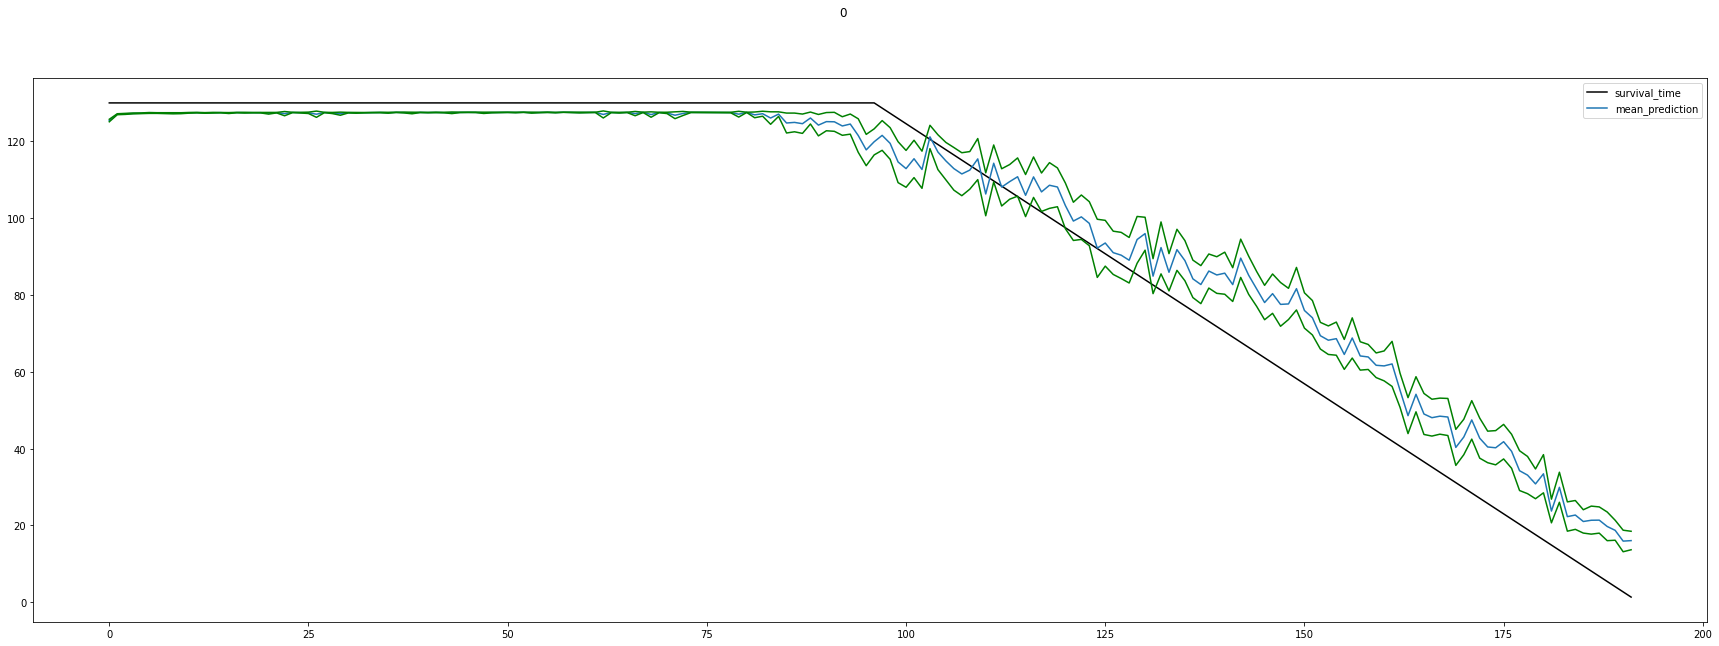

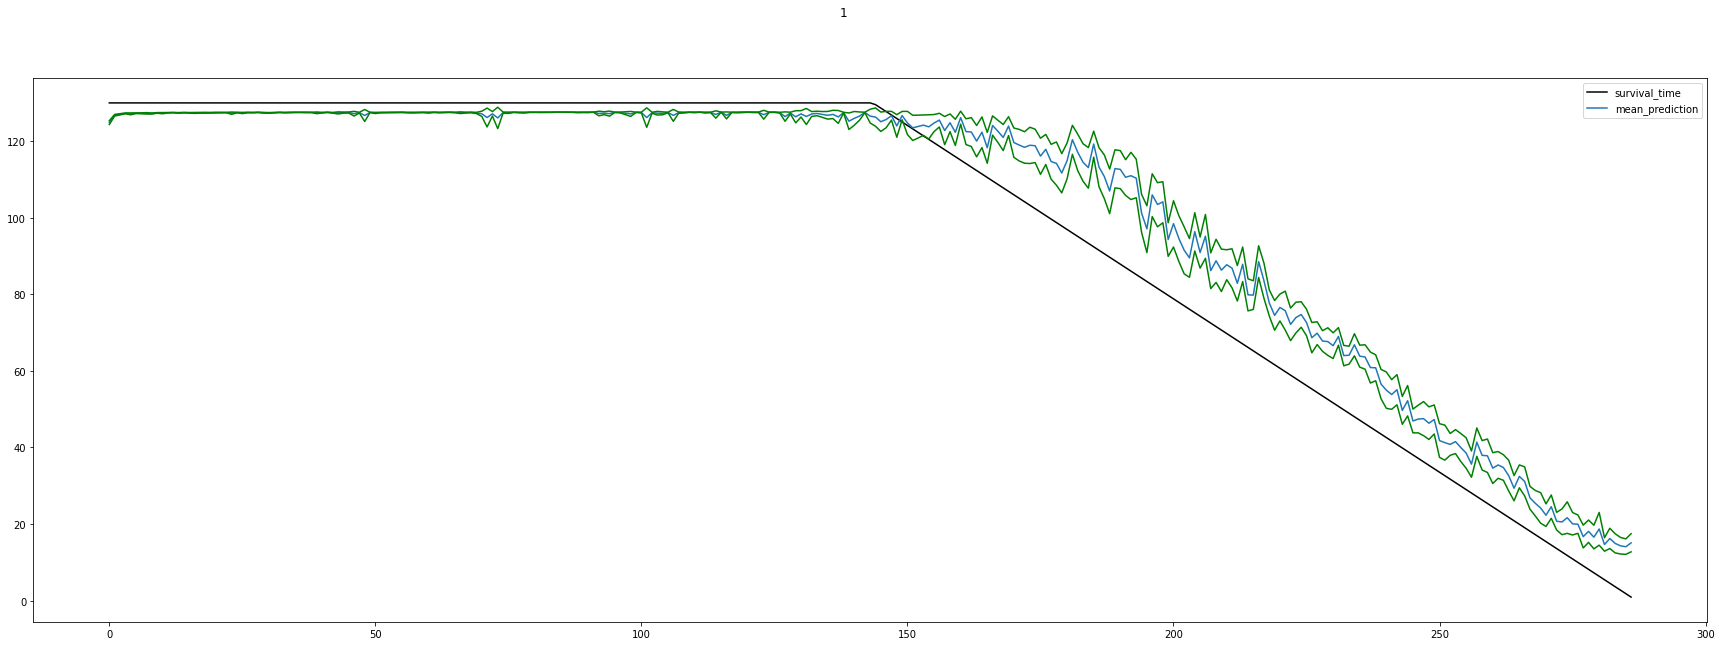

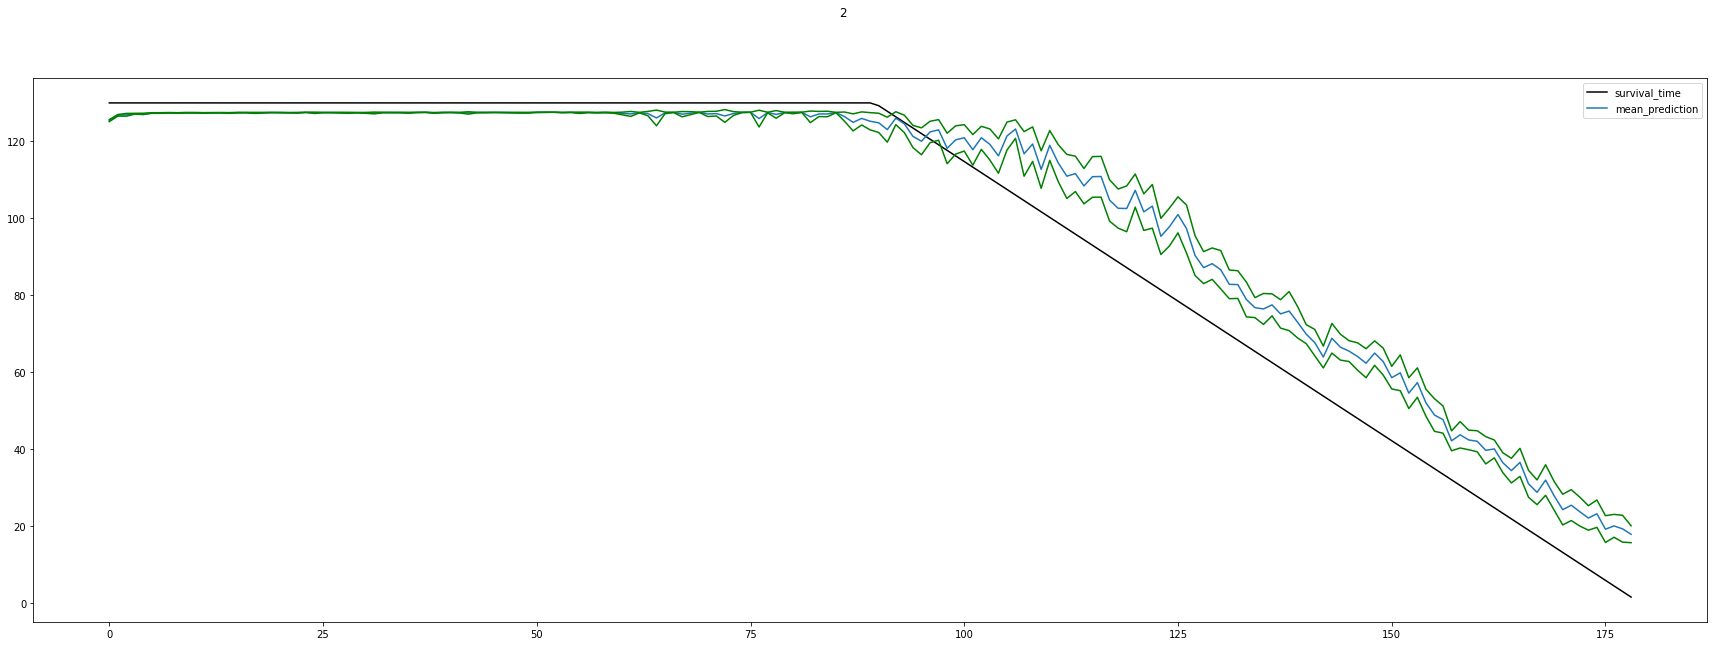

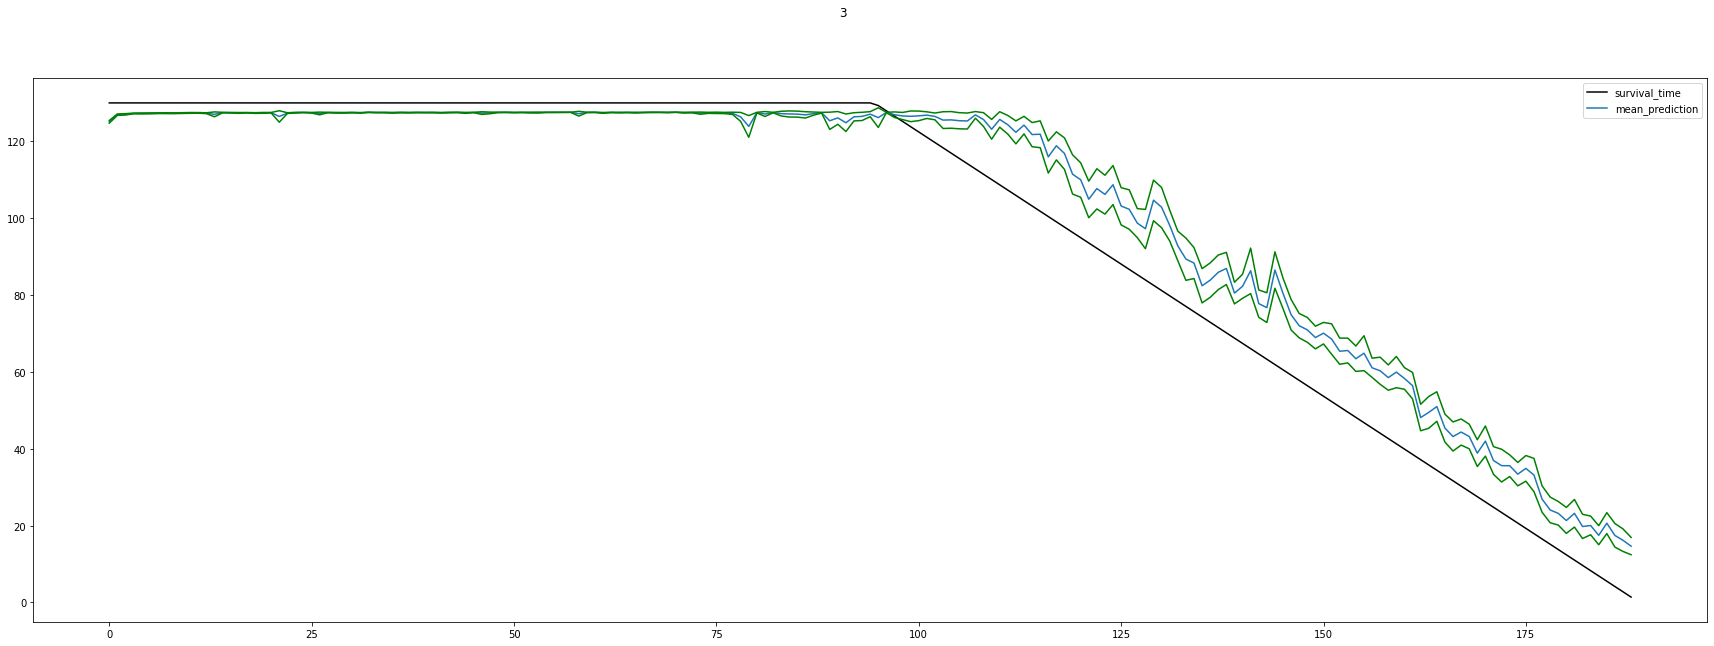

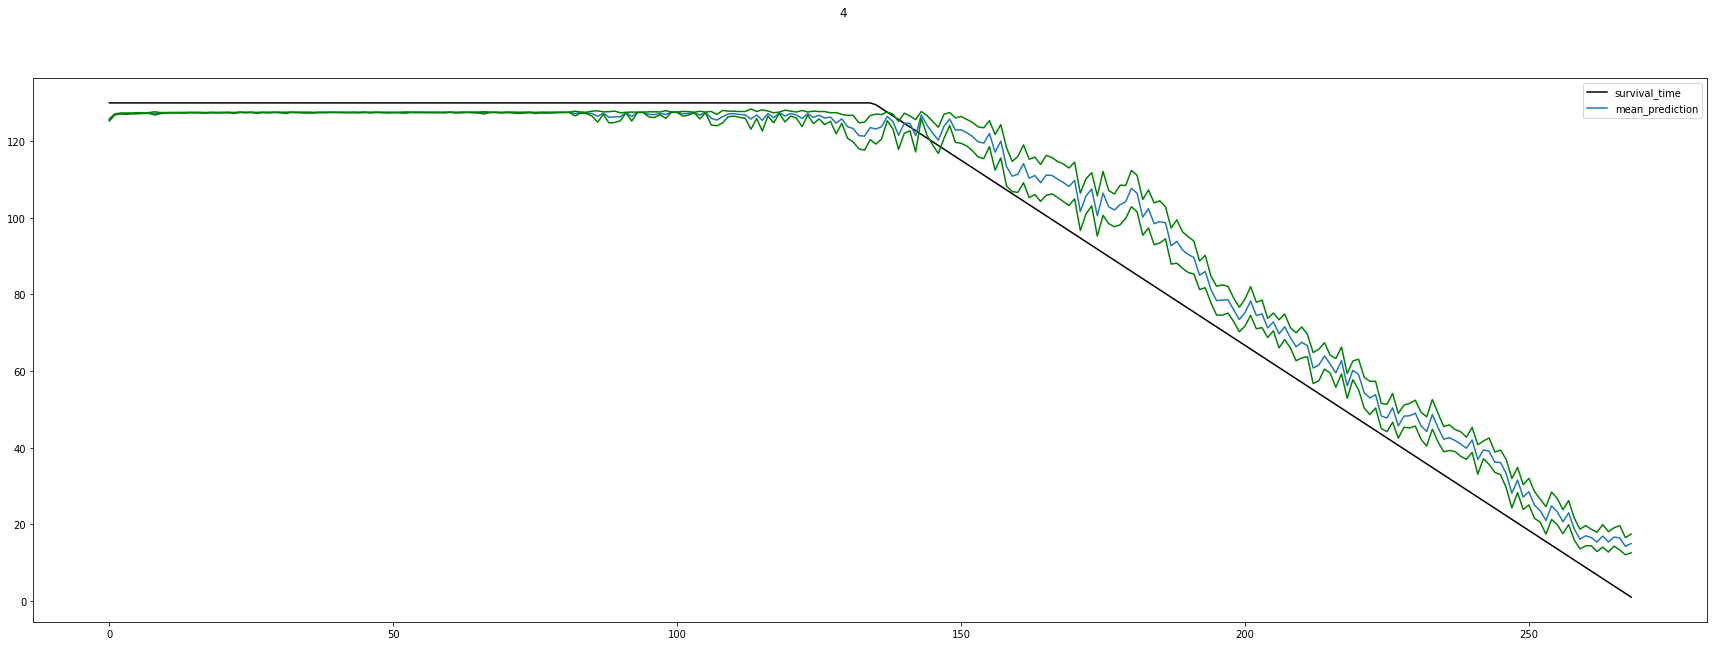

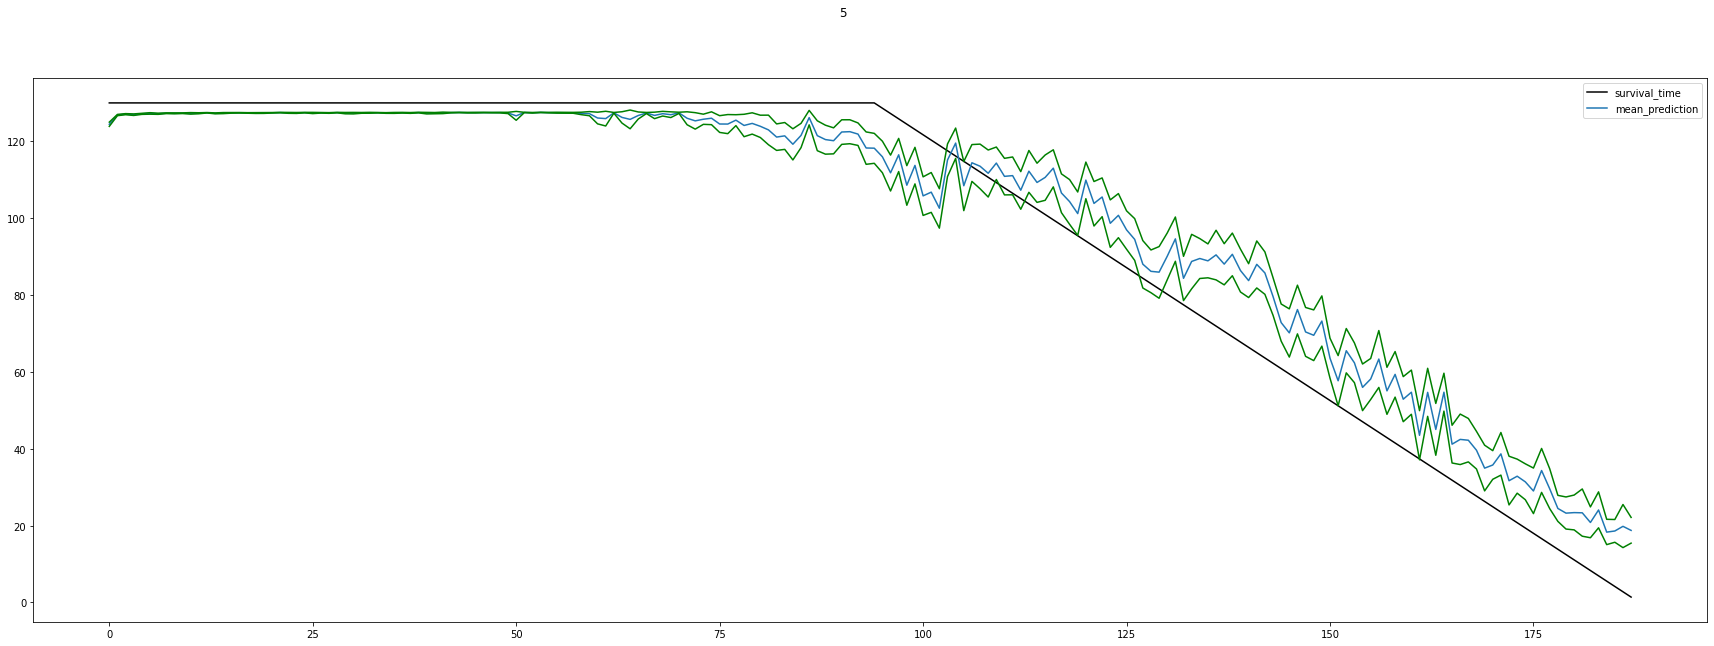

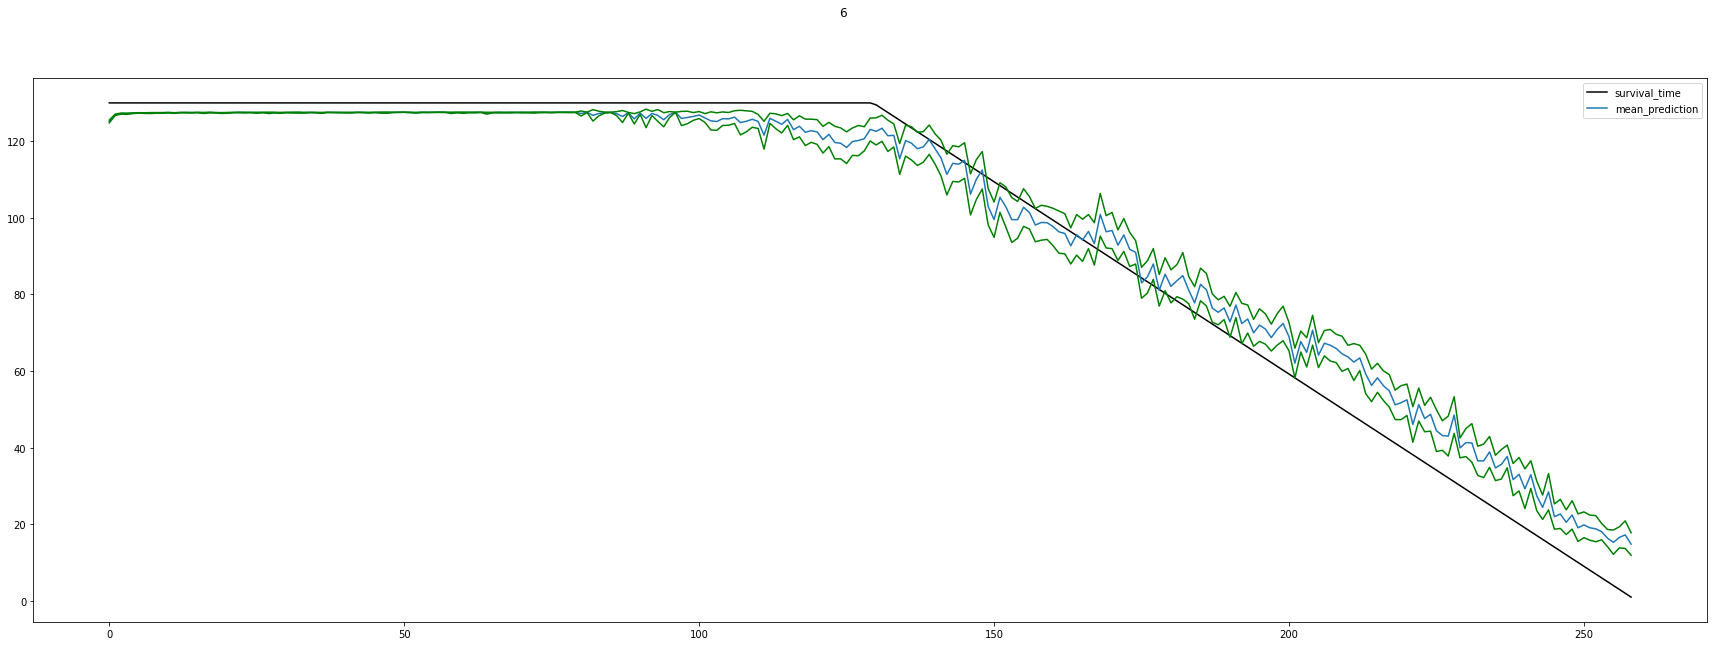

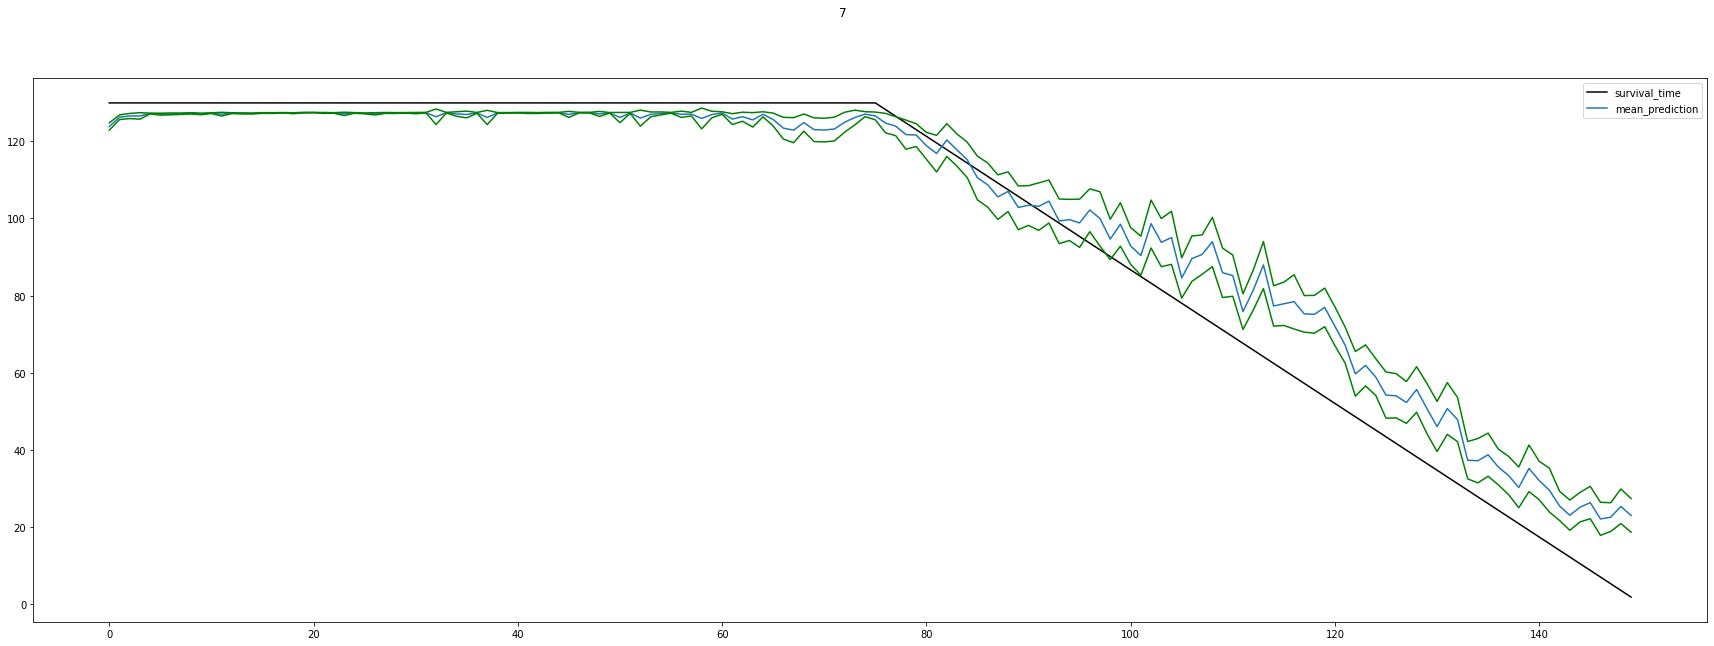

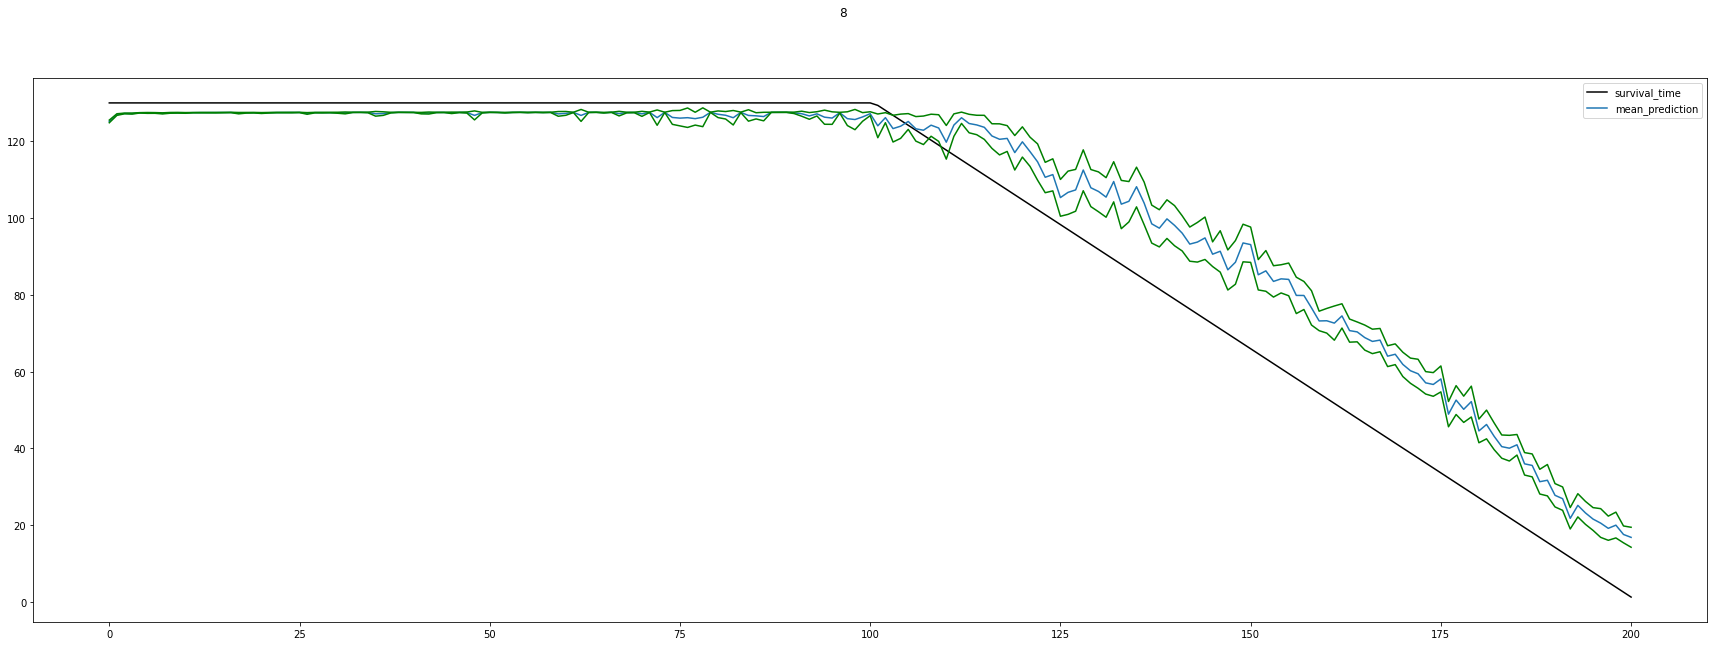

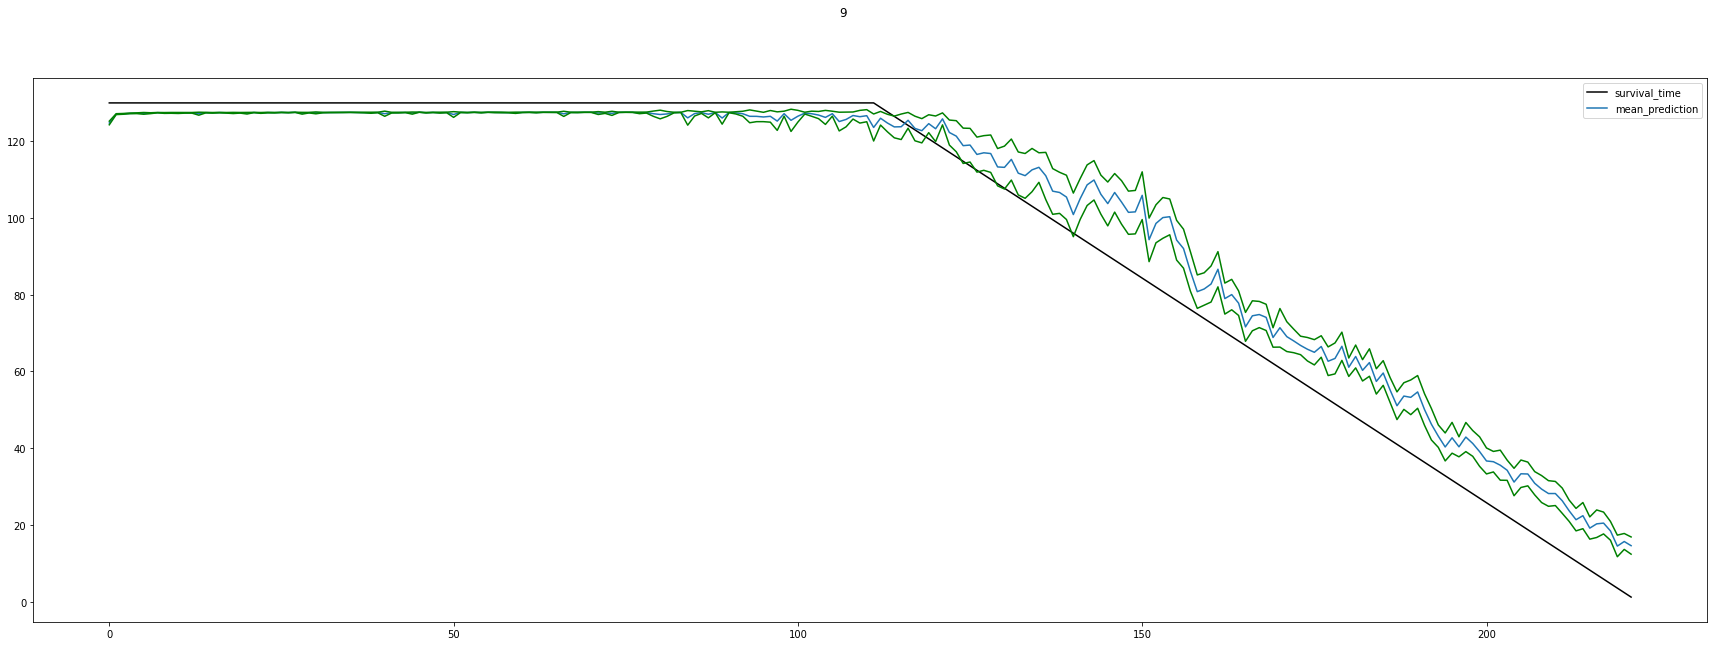

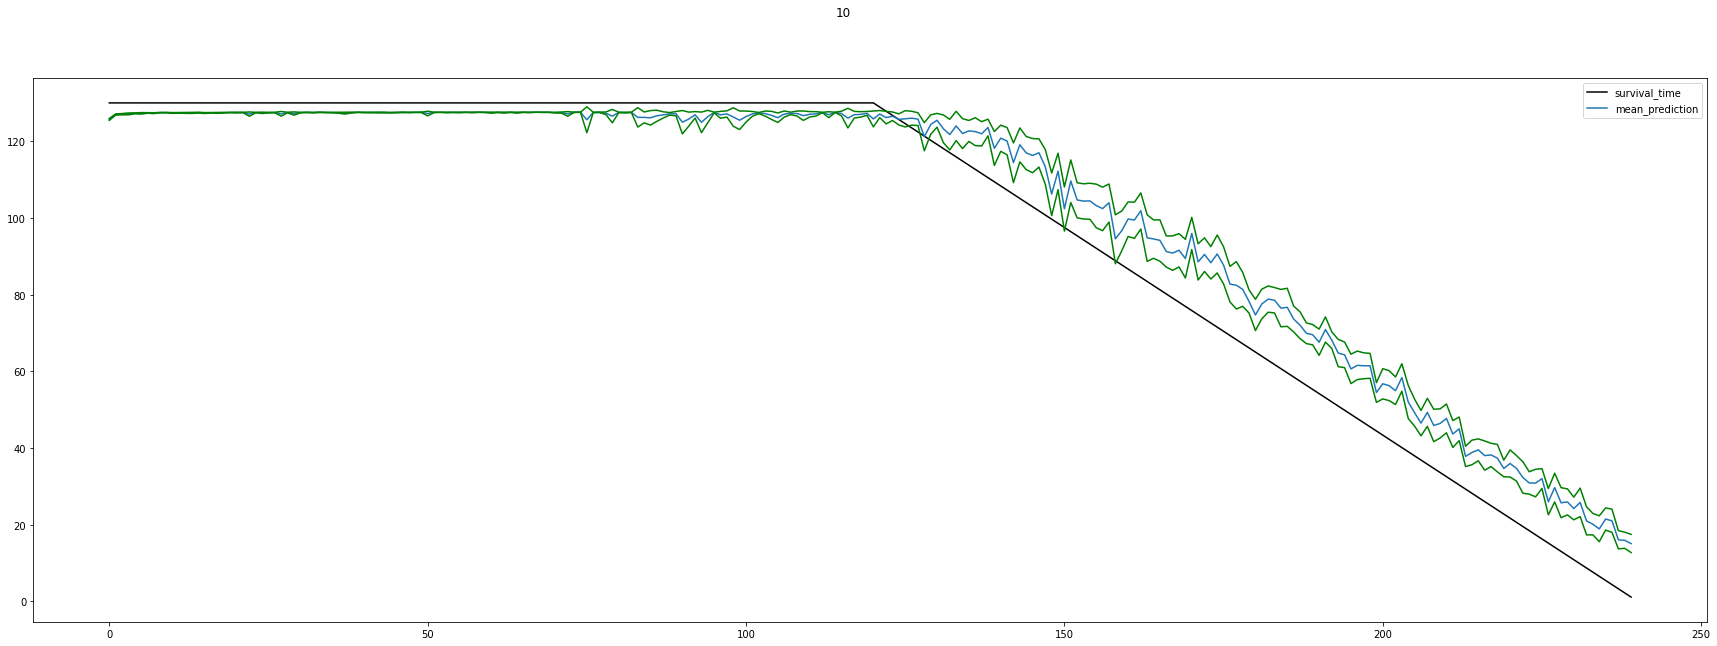

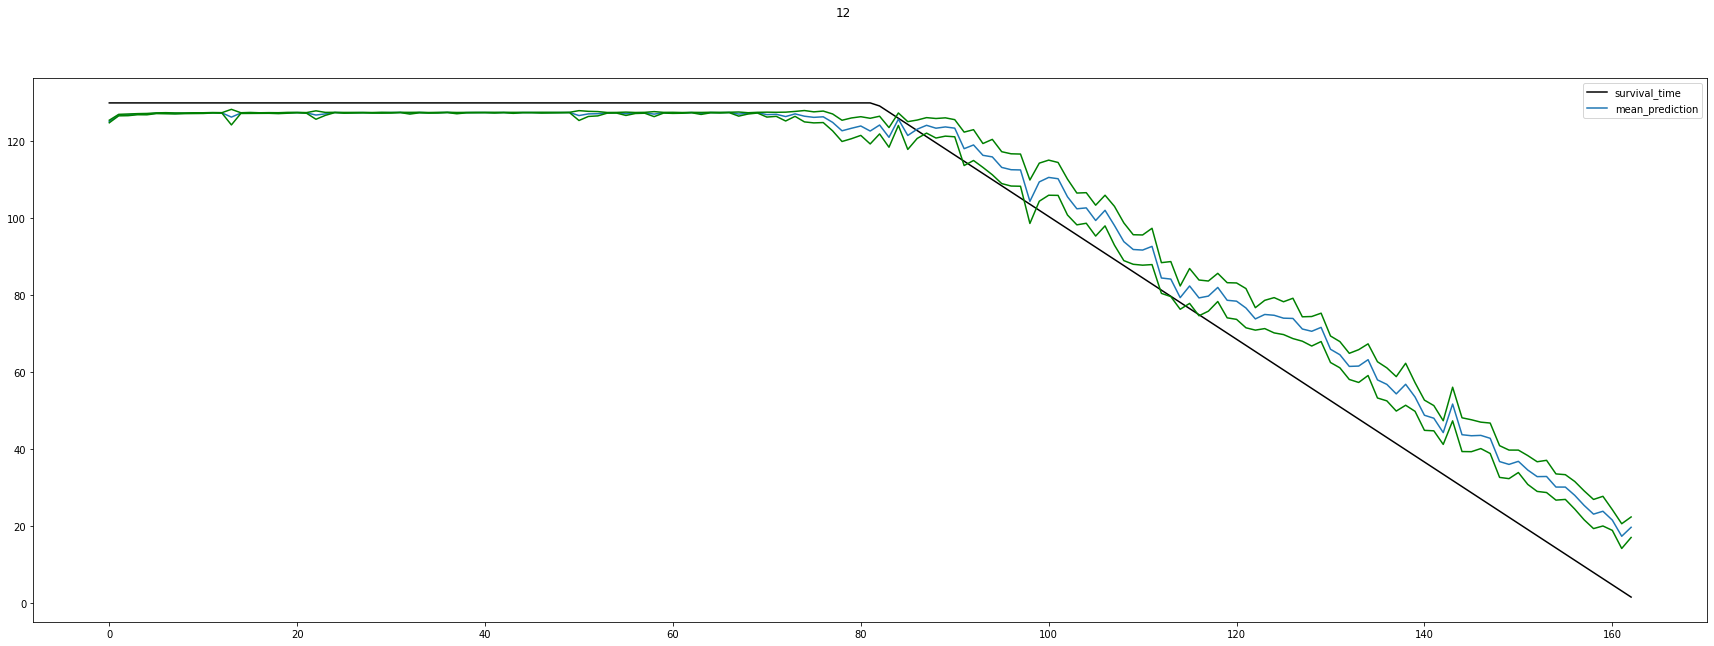

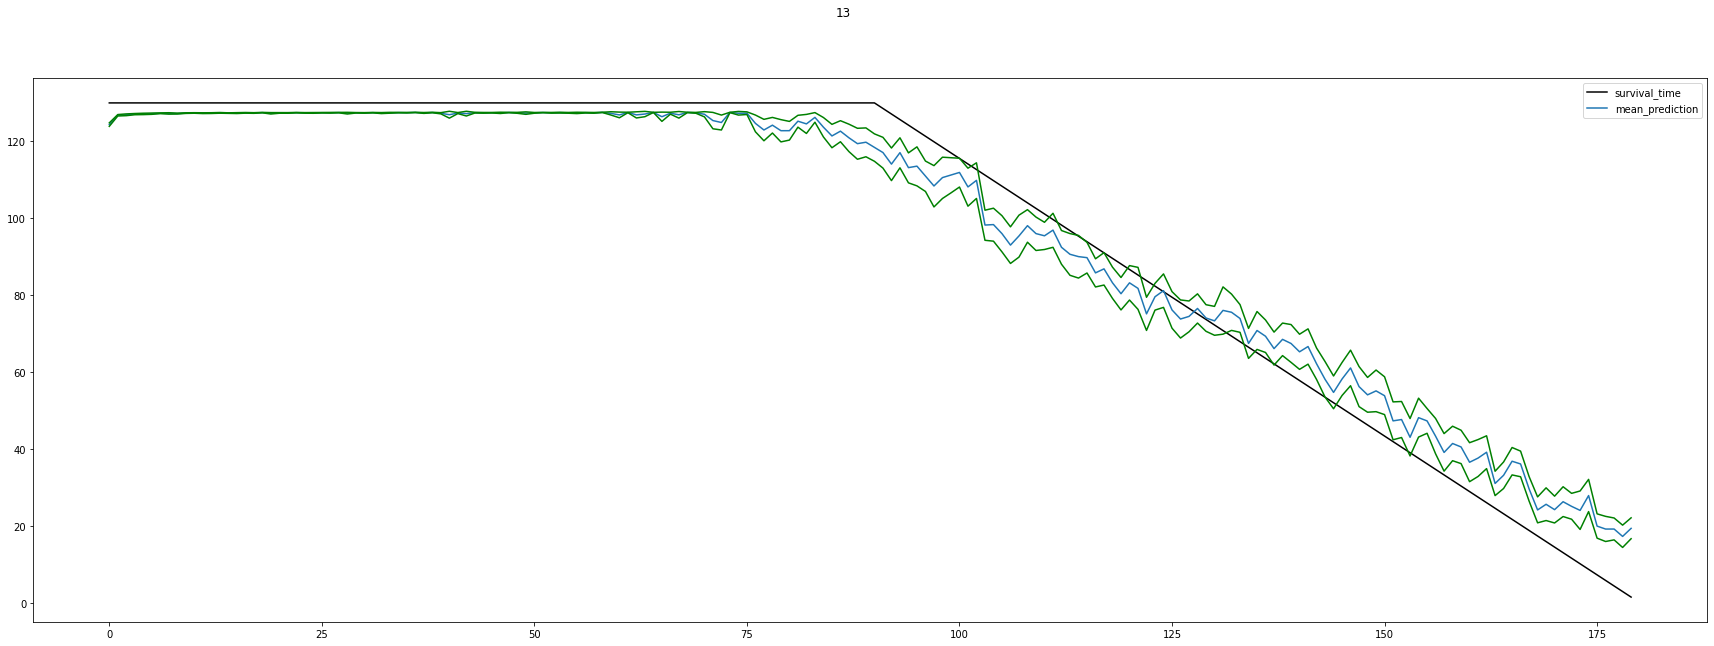

KeyboardInterrupt: 

In [69]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp, unit_number)

***

# Model explanation

We create a function

In [40]:
# parameters

max_time = 100 
mask_value = -99
cv = 10
fold_count = 0
shuffle = True
random_state = 21
reps = 30

epochs = 10
batch_size = 64

In [41]:
def create_data(train_x_orig):
    
    kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    for train_units, test_units in kf.split(train_x_orig.unit_number.unique()):

        global fold_count
        fold_count+= 1
        print(f'Fold: {fold_count}')
        tf.random.set_seed(fold_count)

        # Selecting data
        train_index = train_x_orig[train_x_orig.unit_number.isin(train_units)].index
        test_index = train_x_orig[train_x_orig.unit_number.isin(test_units)].index # careful this was wrongly test_x_orig. It should be train_x_orig

        X_train = train_x_orig.iloc[train_index]
        X_test_or = train_x_orig.iloc[test_index] # careful this was wrongly test_x_orig. It should be train_x_orig

        X_train.reset_index(drop=True, inplace=True)
        X_test = X_test_or.reset_index(drop=True, inplace=False) # changed for debugging


        # Truncating test data randomly
        X_test_trunc = []
        test_y = []
        max_cycle = []
        test_index = [] # for debugging purposes
        temp_or_test_cycles = []
        for i in set(X_test.unit_number.unique()):
            np.random.seed(i)
    #         print(i)
            temp_df = X_test[X_test.unit_number==i]
            temp_df.reset_index(drop=True, inplace=True) # important
            length = temp_df.shape[0]
            temp_or_test_cycles.append(length)
            level = np.random.choice(np.arange(5, 96), 1)[0]  
            r = np.int(length*(1-level/100))
            test_index.append(X_test_or[X_test_or.unit_number==i].index.tolist()[:r+1]) # check this with train_x_orig instead of X_test_or (probably it's the same)
            temp_df = temp_df.truncate(after=r)
            max_cycle.append(temp_df.shape[0])
            X_test_trunc.append(temp_df)

        test_index = [item for sublist in test_index for item in sublist]

        X_test_trunc = pd.concat(X_test_trunc)
        X_test_trunc.reset_index(drop=True, inplace=True)


        # Pre-processing data
        scaler=pipeline.Pipeline(steps=[
         ('minmax', MinMaxScaler(feature_range=(-1, 1))),
         ('remove_constant', VarianceThreshold())])

        train = X_train.copy()
        train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)

        test = X_test_trunc.copy()
        test = np.concatenate([test[['unit_number', 'time']], scaler.transform(test[feature_cols])], axis=1)


        # Preparing data for the RNN (numpy arrays)
        train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                                      is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')

        test_x, test_y = build_data(units=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time,
                           is_test=True, mask_value=mask_value, original_data=X_test_or, label='nonlinear') 
        print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)
        
#         model.predict()
        
        break
        
    return train_x, train_y, test_x, test_y

In [42]:
train_x, train_y, test_x, test_y = create_data(train_x_orig)

  8%|▊         | 7/90 [00:00<00:01, 65.31it/s]

Fold: 1


100%|██████████| 10/10 [00:00<00:00, 1177.88it/s]

train_x (18597, 100, 17) train_y (18597, 1) test_x (10, 100, 17) test_y (10, 1)


In [32]:
shap.__version__

'0.39.0'

In [35]:
# train_x_reshaped = train_x.reshape(train_x.shape[0]*train_x.shape[1], train_x.shape[2])

In [37]:
# train_x_kmeans = shap.kmeans(train_x_reshaped, 10)

In [44]:
explainer = shap.DeepExplainer(model, train_x[:100])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [40]:
test_x_reshaped = test_x.reshape(1000,17)

In [41]:
test_x_reshaped.shape

(1000, 17)

In [46]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [47]:
shap_values = explainer.shap_values(test_x[:2])

TypeError: Tensors are unhashable. (KerasTensor(type_spec=TensorSpec(shape=(?, 100, 17), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"))Instead, use tensor.ref() as the key.

In [41]:
test_x_reshaped[:,17]

IndexError: index 17 is out of bounds for axis 1 with size 17

***

# Training the entire model

In [78]:
def network(train_X, train_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
#     tensorboard = callbacks.TensorBoard(log_dir = './logs_2D')

    n_features = train_X.shape[-1]

    # Start building our model
    model = Sequential()
    # Mask parts of the lookback period that are all _mask_value_ (i.e., unobserved) so they don't skew the model
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
#     model.add(BatchNormalization())
    model.add(GRU(100, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(20, activation='tanh', return_sequences=False))
    model.add(Dense(2))
    custom_activation = Activate()
    model.add(BatchNormalization())
    model.add(Activation(custom_activation))

    
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss=CustomLoss(kind='continuous', reduce_loss=True), optimizer=Adam(lr=.01, clipvalue=0.5))#, metrics=['mse', rmse]) #CustomLoss(kind='mttf', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              #validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping], # , tensorboard
              workers=32)
    

    return model, history

In [86]:
# parameters

try:
    del model
except NameError:
    pass
k.clear_session()

max_time = 100 
mask_value = -99

epochs = 10
batch_size = 64


scaler=pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())])

train = train_x_orig.copy()
train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)


train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                              is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')

print(train_x.shape)

# initialization
tte_mean_train = np.nanmean(train_y)#[:, 0]) # (uncomment when adding event)
mean_u = 1.0 #np.nanmean(train_y[:, 1]) # (uncomment when adding event)

# Initialization value for alpha-bias
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
init_alpha = init_alpha / mean_u
# print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)

print('train_x', train_x.shape, 'train_y', train_y.shape)

# training
model, history = network(train_x, train_y, mask_value, epochs, batch_size, init_alpha)

100%|██████████| 260/260 [00:06<00:00, 37.89it/s]


(53759, 100, 24)
train_x (53759, 100, 24) train_y (53759, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 24)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 100)         37800     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 100)         400       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 50)          200       
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                4320      
_____________________________________________________________

testing

In [87]:
test_or = test_x_orig.copy()
test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


# Preparing data for the RNN (numpy arrays)
test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=max_time,
                   is_test=True, mask_value=mask_value, original_data=test_x_orig)

100%|██████████| 259/259 [00:00<00:00, 1053.33it/s]


In [88]:
test_predict = model.predict(test_or)
test_predict = np.resize(test_predict, (test_or.shape[0], 2))
test_result = np.concatenate((test_y_orig, test_predict), axis=1)
test_results_df = pd.DataFrame(test_result, columns=['T', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)

In [89]:
test_results_df

,T,alpha,beta,unit_number,predicted_mu
0,18.0,8.476152,0.999767,1,8.476989
1,79.0,50.146870,0.999815,2,50.150800
2,106.0,52.526764,0.999817,3,52.530834
3,110.0,43.044880,0.999811,4,43.048327
4,15.0,17.377296,0.999779,5,17.378917
...,...,...,...,...,...
254,122.0,46.121876,0.999812,255,46.125548
255,191.0,64.204002,0.999824,256,64.208780
256,56.0,35.636826,0.999802,257,35.639811
257,131.0,57.953827,0.999820,258,57.958238


In [90]:
np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T']))

54.204774498820925